# RealEstate-Price-Prediction

## Содержание

```
1  Содержание
2  Подготовка данных
2.1  Подключение библиотек
2.2  Загрузка данных
2.3  Описание признаков
2.4  Оптимизация данных
2.4.1  Приведение типов
2.4.2  Оптимизация памяти
3  Визуализация данных
3.1  Распределение Price
3.1.1  Нормальное распределение
3.1.2  Преобразование искажений
3.2  Распределение HouseYear
3.3  Распределение DistrictId
3.4  Потерянные данные
3.5  Корреляция
4  Технический анализ
4.1  Функция Fix Rooms
4.2  Функция Fix Square
4.3  Функция Fix HouseYear
5  Генерация признаков
5.1  Кластеризация
5.2  Mean Price
5.3  Large District
6  Модели данных + ML
6.1  Блок функций
6.2  Разделение датасета
6.3  Модель Linear Regression
6.4  Модель Random Forest Regressor
6.5  Модель Gradient Boosting Regressor
6.6  Модель LassoCV
6.7  Модель LGBMRegressor
6.8  Модель XGBRegressor
7  Результаты
7.1  Выбор лучшей модели
7.2  Прогноз по входным данным
```

## Подготовка данных


### Подключение библиотек

In [1]:
# Основные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

# Визуализация данных
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from pylab import rcParams
plt.style.use('default')
# plt.style.use('ggplot')
# %config InlineBackend.figure_format = 'svg'
# plt.figure(figsize=(10, 6))
# plt.rcParams.update({'font.size': 14})
plt.rc('font', size=14)         # размер шрифта по умолчанию
plt.rc('axes', titlesize=13)    # размер шрифта оси
plt.rc('axes', labelsize=13)    # размер шрифта для меток x и y
plt.rc('xtick', labelsize=11)   # размер шрифта по оси х
plt.rc('ytick', labelsize=11)   # размер шрифта по оси y
plt.rc('legend', fontsize=10)   # размер шрифта legend
plt.rc('figure', titlesize=16)  # размер шрифта figure title
%matplotlib inline

# Представление данных
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Машинное обучение
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Целевая переменная
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Загрузка данных

In [2]:
def df_read_csv(df):
    # train = df_read_csv('train')
    # test = df_read_csv('test')
    if df == 'train':
        TRAIN_DATASET_PATH = 'dataset/train.csv'
        df = pd.read_csv(TRAIN_DATASET_PATH)
        print(f"Train:\t{df.shape[0]}\t sales and {df.shape[1]} features")
    elif df == 'test':
        TEST_DATASET_PATH = 'dataset/test.csv'
        df = pd.read_csv(TEST_DATASET_PATH)
        print(f'Test:\t{df.shape[0]}\t sales and {df.shape[1]} features')
    else:
        print('Invalid parameter: dataset name!')
    return df

In [3]:
# Загрузка данных
train = df_read_csv('train')

Train:	10000	 sales and 20 features


In [4]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Описание признаков

```
Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры
```

### Оптимизация данных

#### Приведение типов

In [6]:
def df_type_cast(df, column_name, column_type):
    # df_type_cast('train', 'Rooms', 'int64')
    # df_type_cast('test', 'Rooms', 'int64')
    if df == 'train':
        train[column_name] = train[column_name].astype(column_type)
        print(f"New Type '{column_name}': {train[column_name].dtype}")
    elif df == 'test':
        test[column_name] = test[column_name].astype(column_type)
        print(f"New Type '{column_name}': {test[column_name].dtype}")
    else:
        print('Invalid parameters!')

In [7]:
# Меняем тип данных
df_type_cast('train', 'Rooms', 'int64')
df_type_cast('train', 'HouseFloor', 'int64')

New Type 'Rooms': int64
New Type 'HouseFloor': int64


#### Оптимизация памяти

In [8]:
def optimizing_df(df):
    # train = optimizing_df(train)
    # test = optimizing_df(test)
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [9]:
# Оптимизируем использование памяти
train = optimizing_df(train)

In [10]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

## Визуализация данных

### Распределение Price

#### Нормальное распределение

mu = 214138.86 and sigma = 92867.65


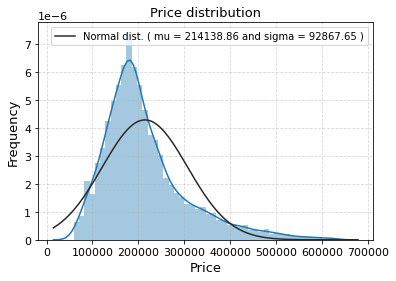

In [11]:
# Строим гистограмму и график плотности распределения целевой переменной
sns.distplot(train['Price'], fit=norm)
mu, sigma = norm.fit(train['Price'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')
plt.grid(linestyle='--', alpha=0.5)
plt.legend([f'Normal dist. ( mu = {mu:.2f} and sigma = {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')
plt.show()

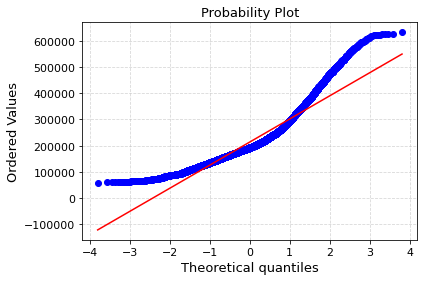

In [12]:
# QQ-plot (квантиль-квантиль)
# Создаем график распределений вероятности (probability) по квантилям целевой переменной
# Сравнение двух распределений вероятности путем построения их квантилей относительно друг друга
# В случае сравнения двух выборок данных, квантиль упорядочивает данные 
# (формально вычисляет статистику упорядочения), а затем строит их в зависимости 
# от определенных квантилей теоретического распределения
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

#### Преобразование искажений

mu = 214138.86 and sigma = 92867.65


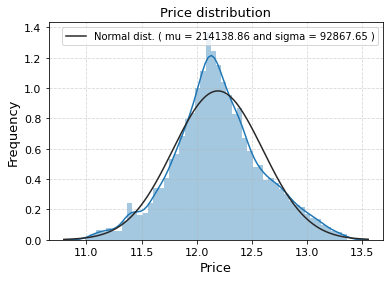

In [13]:
# Преобразуем искажения в нормальное распределение
# log1p обеспечивает более однородное распределение, когда набор данных содержит числа, близкие к нулю
# т.е. производит преобразование искаженного распределения в нормальное распределение
price_log = np.log1p(train['Price'])
sns.distplot(price_log, fit=norm)
mu, sigma = norm.fit(train['Price'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')
plt.grid(linestyle='--', alpha=0.5)
plt.legend([f'Normal dist. ( mu = {mu:.2f} and sigma = {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')
plt.show()

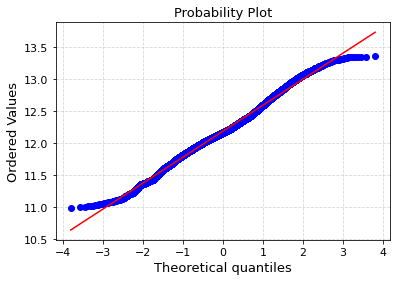

In [14]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

### Распределение HouseYear

Text(0.5, 1.0, 'Distribution of variable House Year')

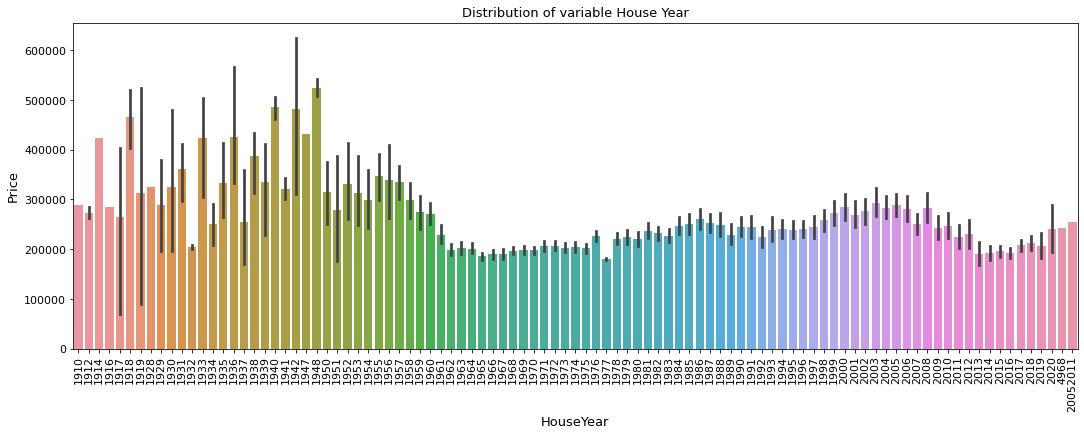

In [15]:
plt.figure(figsize=(18, 6))
sns.barplot(train['HouseYear'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')

### Распределение DistrictId

Text(0.5, 1.0, 'Distribution of variable District Id')

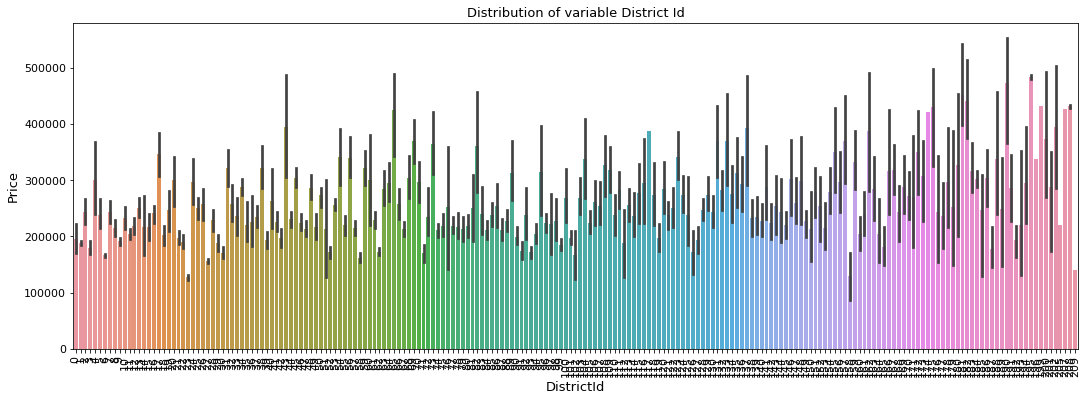

In [16]:
plt.figure(figsize=(18, 6))
sns.barplot(train['DistrictId'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable District Id')

### Потерянные данные

In [17]:
all_data = train.reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
all_data

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401787,30.476204,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B
9996,6159,18,1,41.521545,20.539215,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A
9997,5123,27,1,47.939007,NaN,1.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A
9998,5400,75,2,43.602562,33.840149,8.0,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B


In [18]:
# Определяем % недостающих данных
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

,Missing Ratio
Healthcare_1,47.98
LifeSquare,21.13


In [19]:
# Удаление недостающих данных
def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100

    df_na = df_na.drop(
        df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

# Замена потерянных значений медианой
def df_median_missing(df):
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median() 
    return df

### Корреляция

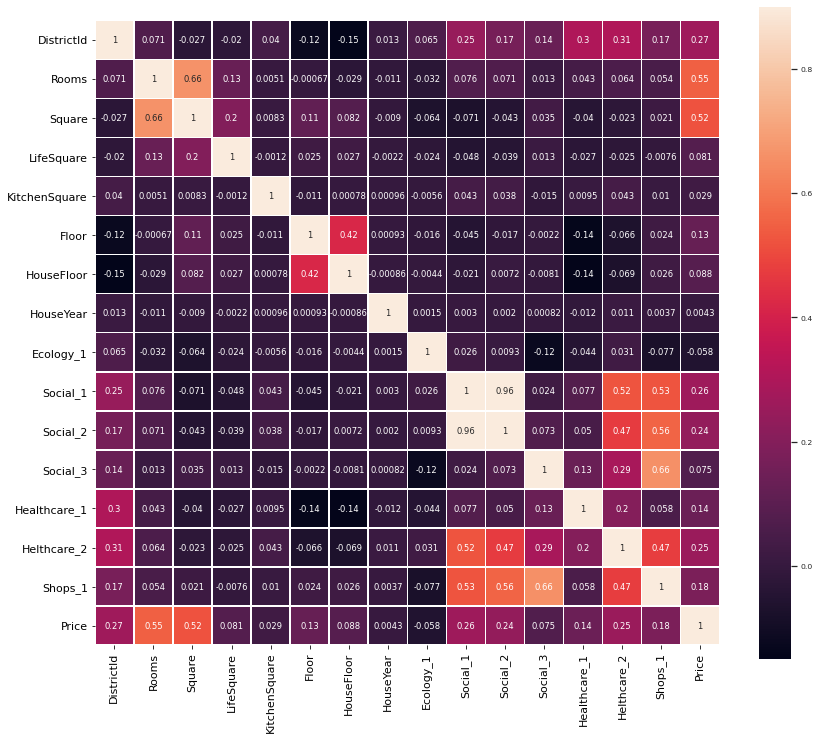

In [20]:
# Строим тепловую карту
# Визуализируем матрицу корреляций и ввиде тепловой карты
corrmat = train.loc[:, train.columns != 'Id'].corr()
# Применяем стили только для этого графика:
plt.subplots(figsize=(14, 12))
with sns.axes_style('ticks'):
    sns.set(font_scale=0.7)
    sns.heatmap(corrmat, vmax=0.9, square=True, annot=True, linewidths=.5)

In [21]:
# Фиксим шрифты
plt.rc('font', size=14)         # размер шрифта по умолчанию
plt.rc('axes', titlesize=13)    # размер шрифта оси
plt.rc('axes', labelsize=13)    # размер шрифта для меток x и y
plt.rc('xtick', labelsize=11)   # размер шрифта по оси х
plt.rc('ytick', labelsize=11)   # размер шрифта по оси y
plt.rc('legend', fontsize=10)   # размер шрифта legend
plt.rc('figure', titlesize=16)  # размер шрифта figure title

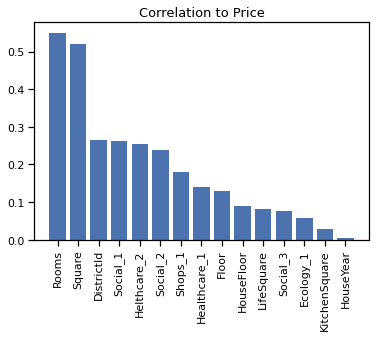

In [22]:
# Строим график корреляции
# Вычисляем зависимость цены от других признаков
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]

plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [23]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


## Технический анализ

In [24]:
# Выделим данные в отдельный датасет
all_data = train.reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)

In [25]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315777,21.058731,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199646,86.241211,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01


### Функция Fix Rooms

In [26]:
all_data.loc[all_data['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
377,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B
1454,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B
8849,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B


In [27]:
all_data.loc[all_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1397,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
2269,7317,27,0,41.790882,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B
4366,456,6,0,81.491447,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B
8834,9443,27,0,87.762619,85.125473,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B


In [28]:
def df_fix_room(df):
    # Вычисляем среднюю площадь комнаты по районам
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)
    
    # Присоединяем к датасету
    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    # Заполняем средним значением
    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    # Корректируем наблюдения > 6
    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    # Корректируем наблюдения = 0
    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

### Функция Fix Square

In [29]:
all_data.loc[all_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6977,11602,30,2,641.065186,638.163208,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
4262,28,9,2,604.705994,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
4690,2307,102,1,409.425171,410.639740,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
1982,5548,86,5,275.645294,233.949310,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
9910,16568,27,4,200.334534,201.627365,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B


mu = 56.32 and sigma = 21.06


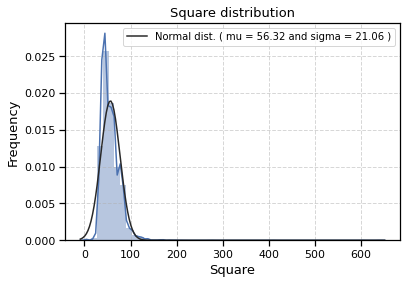

In [30]:
# Распределение площади
sns.distplot(all_data['Square'], fit=norm)
mu, sigma = norm.fit(all_data['Square'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')
plt.grid(linestyle='--', alpha=0.5)
plt.legend([f'Normal dist. ( mu = {mu:.2f} and sigma = {sigma:.2f} )'])
plt.title('Square distribution')
plt.ylabel('Frequency')
plt.show()

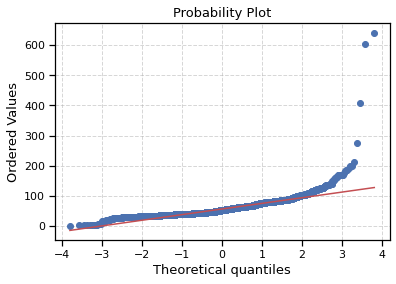

In [31]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['Square'], plot=plt)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [32]:
# Если площадь > 400, то / 10
def df_fix_square_manual(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

In [33]:
def df_fix_square(df):
    # Группируем, считаем среднее и формируем признак
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    # Присоединаяем к df - info_by_district_id
    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    # Исправляем отрицательные значения
    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

In [34]:
# Общая площадь < Жилой
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df

# Заполняем жилую средними значениями
def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

### Функция Fix HouseYear

In [35]:
all_data.loc[all_data['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1497,10814,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
4189,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [36]:
# Корректируем год
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

## Генерация признаков

### Кластеризация

In [37]:
# Масштабируем признаки
scaler = MinMaxScaler()

In [38]:
train_cluster = train.copy()

In [39]:
train_cluster = df_fix_house_year_manual(train_cluster)

In [40]:
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])

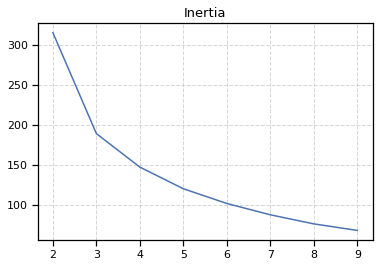

In [41]:
# Кластеризация
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.grid(linestyle='--', alpha=0.5)
plt.title('Inertia')
plt.show()

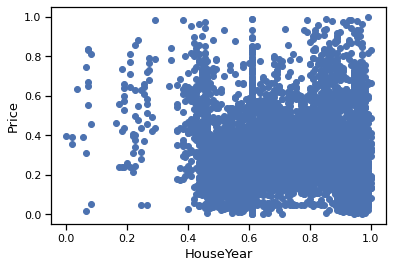

In [42]:
plt.scatter(train_cluster_scaled['HouseYear'], train_cluster_scaled['Price'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.show()

In [43]:
# Разбиваем данные на кластеры
kmeans_model = KMeans(n_clusters=5, random_state=100)

In [44]:
train_labels = kmeans_model.fit_predict(train_cluster_scaled)

Text(0.5, 1.0, 'Train data')

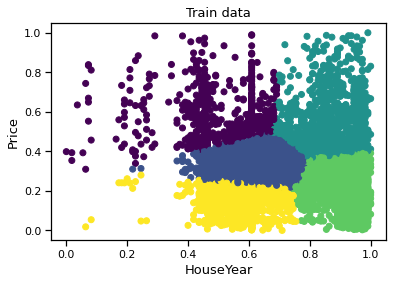

In [45]:
plt.scatter(train_cluster_scaled['HouseYear'],
            train_cluster_scaled['Price'], c=train_labels)

plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train data')

In [46]:
# Объединяем мелкие кластеры в более крупные
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=3)

In [47]:
train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_cluster_scaled)

Text(0.5, 1.0, 'Train')

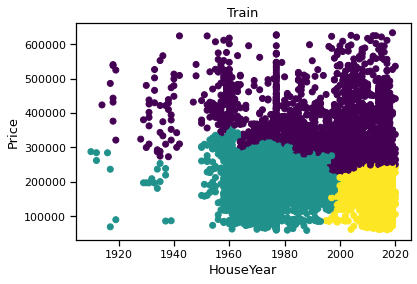

In [48]:
plt.scatter(train_cluster['HouseYear'],
            train_cluster['Price'], c=train_cluster['cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train')

In [49]:
# Создаем признак cluster_year
def add_cluster_year(df):
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
    return df

###  Mean Price

In [50]:
# Создаем признаки mean_price_dr & mean_price_by_rooms
# Средняя цена по кол-ву комнат и Средняя цена по районам и кол-ву комнат
def add_mean_price(df, df_train=train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

### Large District

In [51]:
# Создаем признак large_district
def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df

## Модели данных + ML

### Блок функций
__Объединяем в нужном порядке все функции__

In [52]:
# Объединяем в нужном порядке ранее созданные функции
def data_prepare(df, df_train=train):
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    # df = df_median_missing(df)
    df = add_cluster_year(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    optimizing_df(df)
    return df


# Функция тестирования моделей
def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()


# Рассчитываем стандартное отклонение, SD
def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(10, 'SD')

###  Разделение датасета

In [53]:
print(train.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


In [54]:
# Вычисляем корреляцию
features = list(train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

In [55]:
train[features].head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear
0,2,47.981560,35,33,0,7976,11,NaN,7,9,29.442751,5,0.089040,6.0,1969
1,3,65.683640,41,46,1,10309,16,240.0,7,9,40.049541,1,0.000070,8.0,1978
2,2,44.947952,53,34,1,7759,3,229.0,8,12,29.197611,0,0.049637,0.0,1968
3,2,53.352982,58,23,0,5735,5,1084.0,8,17,52.731510,3,0.437885,9.0,1977
4,1,39.649193,99,35,2,5776,4,2078.0,11,12,23.776169,1,0.012339,7.0,1976


In [56]:
# Создаем словарь для моделей
models_dict = {}

In [57]:
# Внимание! 
# Разделяем датасет на тренировочный и валидационный
# где test = train[target]
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.25, random_state=42)

In [58]:
# Применяем пакет Fix функций
X_train = data_prepare(X_train, train)
X_test = data_prepare(X_test, train)

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                7500 non-null   uint8  
 1   Square               7500 non-null   float32
 2   DistrictId           7500 non-null   uint8  
 3   Social_1             7500 non-null   uint8  
 4   Helthcare_2          7500 non-null   uint8  
 5   Social_2             7500 non-null   uint16 
 6   Shops_1              7500 non-null   uint8  
 7   Floor                7500 non-null   uint8  
 8   HouseFloor           7500 non-null   uint8  
 9   LifeSquare           7500 non-null   float32
 10  Social_3             7500 non-null   uint8  
 11  Ecology_1            7500 non-null   float32
 12  KitchenSquare        7500 non-null   float32
 13  HouseYear            7500 non-null   uint16 
 14  cluster_year         7500 non-null   uint8  
 15  mean_price_dr        7500 non-null   f

In [60]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                2500 non-null   uint8  
 1   Square               2500 non-null   float32
 2   DistrictId           2500 non-null   uint8  
 3   Social_1             2500 non-null   uint8  
 4   Helthcare_2          2500 non-null   uint8  
 5   Social_2             2500 non-null   uint16 
 6   Shops_1              2500 non-null   uint8  
 7   Floor                2500 non-null   uint8  
 8   HouseFloor           2500 non-null   uint8  
 9   LifeSquare           2500 non-null   float32
 10  Social_3             2500 non-null   uint8  
 11  Ecology_1            2500 non-null   float32
 12  KitchenSquare        2500 non-null   float32
 13  HouseYear            2500 non-null   uint16 
 14  cluster_year         2500 non-null   uint8  
 15  mean_price_dr        2500 non-null   f

In [61]:
X_train.head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district
0,1,39.248798,1,1,0,264,1,9,17,35.872440,0,0.007122,0.0,1977,2,147454.609375,159850.796875,505
1,2,56.053581,61,52,1,10311,9,8,12,33.929771,6,0.300323,8.0,1986,2,237598.578125,215256.312500,92
2,1,41.009789,13,74,5,19083,15,3,14,23.960289,2,0.090799,8.0,1997,0,181319.671875,159850.796875,67
3,2,63.640480,9,25,2,5648,4,3,1,58.149242,1,0.161532,1.0,1977,2,187904.062500,215256.312500,236
4,1,49.327911,90,22,3,3151,3,15,23,20.992250,4,0.246032,12.0,2008,0,157979.093750,159850.796875,53


In [62]:
y_train.head()

4901    114363.125000
4375    248648.734375
6698    180347.859375
9805    183697.031250
1101    245768.093750
Name: Price, dtype: float32

### Модель Linear Regression

In [63]:
line_regression_model = LinearRegression()
line_regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
models_dict['Linear Regression'] = line_regression_model

__Тест Linear Regression__

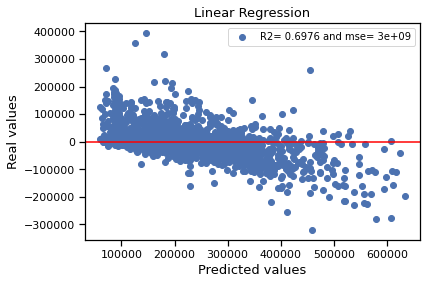

In [65]:
model_test(line_regression_model, 'Linear Regression', X_test, y_test)

In [66]:
model_top_deviation(line_regression_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9,35.747856,...,0.014073,1.0,1977,2,100961.812500,159850.796875,142,105067.953125,571069.062500,466001.12500
1918,1,46.869541,1,1,0,264,1,16,24,35.747856,...,0.007122,1.0,1977,2,147454.609375,159850.796875,147,162689.312500,594565.312500,431876.00000
2094,4,98.385445,69,33,1,6783,9,14,22,76.081772,...,0.000991,9.0,1979,2,500774.125000,383251.093750,7,492688.093750,91775.320312,400912.78125
350,3,126.621361,24,50,2,12238,3,22,48,62.455482,...,0.111627,12.0,2011,0,361843.250000,289337.968750,10,498039.250000,100226.367188,397812.87500
511,1,43.613430,6,5,0,1564,0,3,17,3.668460,...,0.243205,1.0,2016,0,135294.171875,159850.796875,135,131243.437500,518952.656250,387709.21875
1957,5,117.855972,169,18,1,3594,5,12,14,76.561317,...,0.178917,9.0,2001,0,608674.125000,410431.593750,4,612138.000000,226513.890625,385624.12500
1298,3,66.674217,137,23,2,3975,0,8,10,43.174759,...,0.200147,9.0,1954,1,475467.500000,289337.968750,3,448390.031250,91325.367188,357064.65625
866,1,40.043236,6,5,0,1564,0,3,17,40.043236,...,0.243205,1.0,2014,0,135294.171875,159850.796875,135,121631.632812,474624.218750,352992.59375
879,1,17.498543,0,25,5,4756,8,7,5,13.446544,...,0.319809,0.0,1961,1,141262.609375,159850.796875,12,93760.812500,440809.062500,347048.25000
385,3,77.985397,6,5,0,1564,0,4,17,35.747856,...,0.243205,12.0,1977,2,214231.906250,289337.968750,135,207331.250000,547029.875000,339698.62500


### Модель Random Forest Regressor

In [67]:
random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [68]:
models_dict['Random Forest Regressor'] = random_forest_regressor_model

__Тест Random Forest Regressor__

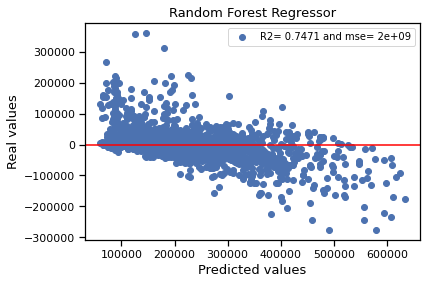

In [69]:
model_test(random_forest_regressor_model,
           'Random Forest Regressor', X_test, y_test)

In [70]:
model_top_deviation(random_forest_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9,35.747856,...,0.014073,1.0,1977,2,100961.812500,159850.796875,142,109386.685078,571069.062500,461682.377422
1918,1,46.869541,1,1,0,264,1,16,24,35.747856,...,0.007122,1.0,1977,2,147454.609375,159850.796875,147,155956.897031,594565.312500,438608.415469
2094,4,98.385445,69,33,1,6783,9,14,22,76.081772,...,0.000991,9.0,1979,2,500774.125000,383251.093750,7,488716.682188,91775.320312,396941.361875
350,3,126.621361,24,50,2,12238,3,22,48,62.455482,...,0.111627,12.0,2011,0,361843.250000,289337.968750,10,490587.791875,100226.367188,390361.424687
511,1,43.613430,6,5,0,1564,0,3,17,3.668460,...,0.243205,1.0,2016,0,135294.171875,159850.796875,135,137112.010703,518952.656250,381840.645547
461,3,68.746971,23,0,0,168,0,12,17,64.210121,...,0.034656,1.0,2017,0,170912.203125,289337.968750,142,131883.147578,497573.375000,365690.227422
866,1,40.043236,6,5,0,1564,0,3,17,40.043236,...,0.243205,1.0,2014,0,135294.171875,159850.796875,135,123966.527891,474624.218750,350657.690859
1298,3,66.674217,137,23,2,3975,0,8,10,43.174759,...,0.200147,9.0,1954,1,475467.500000,289337.968750,3,432626.298594,91325.367188,341300.931406
1957,5,117.855972,169,18,1,3594,5,12,14,76.561317,...,0.178917,9.0,2001,0,608674.125000,410431.593750,4,564058.453750,226513.890625,337544.563125
385,3,77.985397,6,5,0,1564,0,4,17,35.747856,...,0.243205,12.0,1977,2,214231.906250,289337.968750,135,216395.676797,547029.875000,330634.198203


### Модель Gradient Boosting Regressor

In [71]:
gradient_boosting_regressor_model = GradientBoostingRegressor()
gradient_boosting_regressor_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
models_dict['Gradient Boosting Regressor'] = gradient_boosting_regressor_model

__Тест Gradient Boosting Regressor__

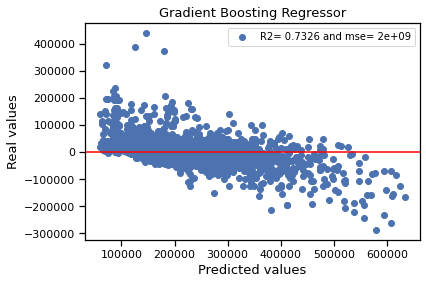

In [73]:
model_test(gradient_boosting_regressor_model,
           'Gradient Boosting Regressor', X_test, y_test)

In [74]:
model_top_deviation(gradient_boosting_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
350,3,126.621361,24,50,2,12238,3,22,48,62.455482,...,0.111627,12.0,2011,0,361843.250000,289337.968750,10,553157.718796,100226.367188,452931.351609
23,1,47.347305,23,2,0,475,0,7,9,35.747856,...,0.014073,1.0,1977,2,100961.812500,159850.796875,142,122516.681990,571069.062500,448552.380510
1918,1,46.869541,1,1,0,264,1,16,24,35.747856,...,0.007122,1.0,1977,2,147454.609375,159850.796875,147,148692.912991,594565.312500,445872.399509
2094,4,98.385445,69,33,1,6783,9,14,22,76.081772,...,0.000991,9.0,1979,2,500774.125000,383251.093750,7,505396.333267,91775.320312,413621.012954
511,1,43.613430,6,5,0,1564,0,3,17,3.668460,...,0.243205,1.0,2016,0,135294.171875,159850.796875,135,126076.165932,518952.656250,392876.490318
1298,3,66.674217,137,23,2,3975,0,8,10,43.174759,...,0.200147,9.0,1954,1,475467.500000,289337.968750,3,450468.406651,91325.367188,359143.039464
866,1,40.043236,6,5,0,1564,0,3,17,40.043236,...,0.243205,1.0,2014,0,135294.171875,159850.796875,135,123532.995027,474624.218750,351091.223723
36,4,105.436317,46,31,0,6137,1,23,22,68.823044,...,0.188784,10.0,1998,0,375229.687500,383251.093750,31,448977.287784,103510.226562,345467.061221
461,3,68.746971,23,0,0,168,0,12,17,64.210121,...,0.034656,1.0,2017,0,170912.203125,289337.968750,142,157556.548109,497573.375000,340016.826891
1530,3,98.994911,48,46,1,9515,10,3,0,35.747856,...,0.041125,0.0,1977,2,398124.250000,289337.968750,22,440812.476625,118594.796875,322217.679750


### Модель LassoCV

In [75]:
lasso_cv_model = LassoCV()
lasso_cv_model.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [76]:
models_dict['LassoCV'] = lasso_cv_model

__Тест LassoCV__

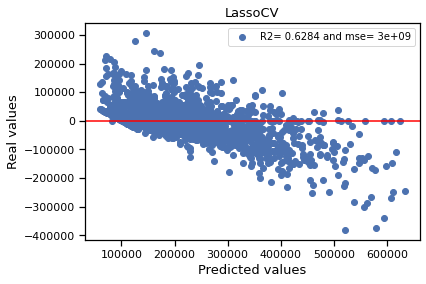

In [77]:
model_test(lasso_cv_model, 'LassoCV', X_test, y_test)

In [78]:
model_top_deviation(lasso_cv_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9,35.747856,...,0.014073,1.0,1977,2,100961.812500,159850.796875,142,101358.835938,571069.062500,469710.21875
1918,1,46.869541,1,1,0,264,1,16,24,35.747856,...,0.007122,1.0,1977,2,147454.609375,159850.796875,147,147622.843750,594565.312500,446942.46875
2094,4,98.385445,69,33,1,6783,9,14,22,76.081772,...,0.000991,9.0,1979,2,500774.125000,383251.093750,7,499203.718750,91775.320312,407428.40625
511,1,43.613430,6,5,0,1564,0,3,17,3.668460,...,0.243205,1.0,2016,0,135294.171875,159850.796875,135,135522.250000,518952.656250,383430.40625
1298,3,66.674217,137,23,2,3975,0,8,10,43.174759,...,0.200147,9.0,1954,1,475467.500000,289337.968750,3,474021.625000,91325.367188,382696.25000
1957,5,117.855972,169,18,1,3594,5,12,14,76.561317,...,0.178917,9.0,2001,0,608674.125000,410431.593750,4,606572.750000,226513.890625,380058.87500
866,1,40.043236,6,5,0,1564,0,3,17,40.043236,...,0.243205,1.0,2014,0,135294.171875,159850.796875,135,135522.250000,474624.218750,339101.96875
465,3,100.252640,27,2,0,629,0,8,1,100.252640,...,0.072158,1.0,1977,2,214083.593750,289337.968750,220,213923.953125,547434.937500,333511.00000
385,3,77.985397,6,5,0,1564,0,4,17,35.747856,...,0.243205,12.0,1977,2,214231.906250,289337.968750,135,214071.531250,547029.875000,332958.34375
461,3,68.746971,23,0,0,168,0,12,17,64.210121,...,0.034656,1.0,2017,0,170912.203125,289337.968750,142,170965.000000,497573.375000,326608.37500


In [79]:
all_data.loc[all_data['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
7,11993,74,2,80.312927,NaN,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
8,5172,1,2,64.511436,NaN,1.0,9,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B
12,6452,13,2,54.522804,31.759752,1.0,8,12,1999,0.090799,B,B,74,19083,2,NaN,5,15,B
14,10953,27,1,53.769096,52.408028,1.0,5,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1,38.968338,NaN,1.0,10,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
9986,2996,1,2,64.994247,NaN,1.0,9,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B
9987,15623,23,2,55.620090,NaN,0.0,2,4,1977,0.034656,B,B,0,168,0,NaN,0,0,B
9994,4158,23,2,64.864197,NaN,1.0,17,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B


### Модель LGBMRegressor

In [80]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [81]:
models_dict['LGBMRegressor'] = lgbm_regressor_model

__Тест LGBMRegressor__

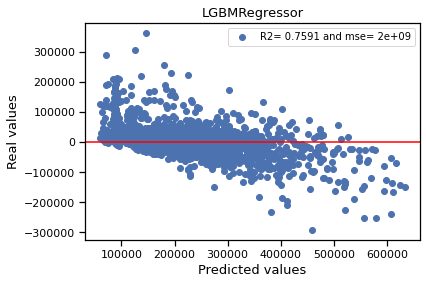

In [82]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_test, y_test)

In [83]:
model_top_deviation(lgbm_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9,35.747856,...,0.014073,1.0,1977,2,100961.812500,159850.796875,142,119508.078949,571069.062500,451560.983551
1918,1,46.869541,1,1,0,264,1,16,24,35.747856,...,0.007122,1.0,1977,2,147454.609375,159850.796875,147,154313.658320,594565.312500,440251.654180
2094,4,98.385445,69,33,1,6783,9,14,22,76.081772,...,0.000991,9.0,1979,2,500774.125000,383251.093750,7,520130.789842,91775.320312,428355.469530
511,1,43.613430,6,5,0,1564,0,3,17,3.668460,...,0.243205,1.0,2016,0,135294.171875,159850.796875,135,129806.696303,518952.656250,389145.959947
1298,3,66.674217,137,23,2,3975,0,8,10,43.174759,...,0.200147,9.0,1954,1,475467.500000,289337.968750,3,453340.037888,91325.367188,362014.670701
461,3,68.746971,23,0,0,168,0,12,17,64.210121,...,0.034656,1.0,2017,0,170912.203125,289337.968750,142,145001.855468,497573.375000,352571.519532
866,1,40.043236,6,5,0,1564,0,3,17,40.043236,...,0.243205,1.0,2014,0,135294.171875,159850.796875,135,125518.826607,474624.218750,349105.392143
385,3,77.985397,6,5,0,1564,0,4,17,35.747856,...,0.243205,12.0,1977,2,214231.906250,289337.968750,135,201009.393995,547029.875000,346020.481005
36,4,105.436317,46,31,0,6137,1,23,22,68.823044,...,0.188784,10.0,1998,0,375229.687500,383251.093750,31,437768.011943,103510.226562,334257.785381
350,3,126.621361,24,50,2,12238,3,22,48,62.455482,...,0.111627,12.0,2011,0,361843.250000,289337.968750,10,434329.561066,100226.367188,334103.193879


### Модель XGBRegressor

In [84]:
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [85]:
models_dict['XGBRegressor'] = xgboost_model

__Тест XGBRegressor__

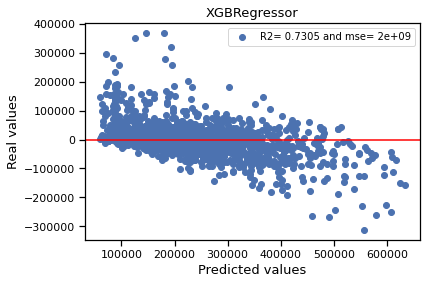

In [86]:
model_test(xgboost_model, 'XGBRegressor', X_test, y_test)

In [87]:
model_top_deviation(xgboost_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9,35.747856,...,0.014073,1.0,1977,2,100961.812500,159850.796875,142,112925.031250,571069.062500,458144.03125
350,3,126.621361,24,50,2,12238,3,22,48,62.455482,...,0.111627,12.0,2011,0,361843.250000,289337.968750,10,549102.812500,100226.367188,448876.43750
1918,1,46.869541,1,1,0,264,1,16,24,35.747856,...,0.007122,1.0,1977,2,147454.609375,159850.796875,147,153344.109375,594565.312500,441221.18750
511,1,43.613430,6,5,0,1564,0,3,17,3.668460,...,0.243205,1.0,2016,0,135294.171875,159850.796875,135,141052.140625,518952.656250,377900.50000
1298,3,66.674217,137,23,2,3975,0,8,10,43.174759,...,0.200147,9.0,1954,1,475467.500000,289337.968750,3,458218.875000,91325.367188,366893.50000
461,3,68.746971,23,0,0,168,0,12,17,64.210121,...,0.034656,1.0,2017,0,170912.203125,289337.968750,142,134968.078125,497573.375000,362605.31250
1530,3,98.994911,48,46,1,9515,10,3,0,35.747856,...,0.041125,0.0,1977,2,398124.250000,289337.968750,22,471156.000000,118594.796875,352561.18750
866,1,40.043236,6,5,0,1564,0,3,17,40.043236,...,0.243205,1.0,2014,0,135294.171875,159850.796875,135,128377.203125,474624.218750,346247.00000
1982,1,48.803200,30,22,3,6398,23,7,5,35.747856,...,0.000078,1.0,1977,2,138446.187500,159850.796875,56,112769.078125,455264.875000,342495.81250
1957,5,117.855972,169,18,1,3594,5,12,14,76.561317,...,0.178917,9.0,2001,0,608674.125000,410431.593750,4,565292.437500,226513.890625,338778.56250


## Результаты

### Выбор лучшей модели

In [88]:
# Функция R2
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

In [89]:
models_score_test = models_r2(models_dict, X_test, y_test)
models_score_train = models_r2(models_dict, X_train, y_train)

In [90]:
models_score_test[['name', 'r2']]

,name,r2
4,LGBMRegressor,0.759093
1,Random Forest Regressor,0.747123
2,Gradient Boosting Regressor,0.732639
5,XGBRegressor,0.730473
0,Linear Regression,0.697608
3,LassoCV,0.628441


__Визуализация результатов__

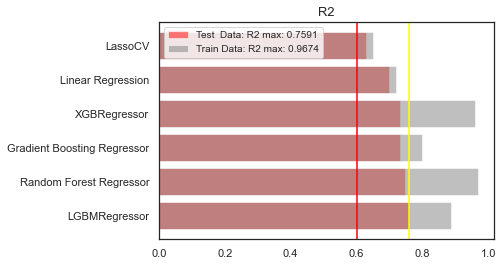

In [91]:
r2_max_test = models_score_test['r2'].max()
r2_max_train = models_score_train['r2'].max()
with sns.axes_style("white"):
    plt.subplots(figsize=(6, 4))
    plt.barh(models_score_test['name'], models_score_test['r2'],
             alpha=0.5, color='red', label=f'Test  Data: R2 max: {r2_max_test:.4f}')
    plt.barh(models_score_train['name'], models_score_train['r2'],
             alpha=0.5, color='grey', label=f'Train Data: R2 max: {r2_max_train:.4f}')
    plt.title('R2')
    plt.legend()
    plt.axvline(0.6, color='red')
    plt.axvline(r2_max_test, color='yellow')
    plt.show()

__Средне квадратическая ошибка__

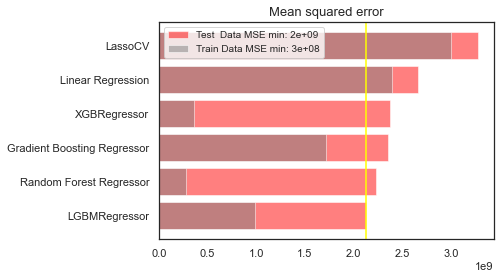

In [92]:
mse_min_test = models_score_test['mse'].min()
mse_min_train = models_score_train['mse'].min()
with sns.axes_style("white"):
    plt.subplots(figsize=(6, 4))
    plt.barh(models_score_test['name'], models_score_test['mse'],
         alpha=0.5, color='red', label=f'Test  Data MSE min: {mse_min_test:.0e}')
    plt.barh(models_score_train['name'], models_score_train['mse'],
             alpha=0.5, color='grey', label=f'Train Data MSE min: {mse_min_train:.0e}')
    plt.title('Mean squared error')
    plt.legend(loc=2)
    plt.axvline(mse_min_test, color='yellow')
    plt.show()

__Лучшая модель__

In [93]:
best_model = models_dict['LGBMRegressor']

In [94]:
pd.DataFrame({'name': list(X_train.columns),
              'importances': list(best_model.feature_importances_)})

,name,importances
0,Rooms,84
1,Square,440
2,DistrictId,176
3,Social_1,139
4,Helthcare_2,34
5,Social_2,120
6,Shops_1,86
7,Floor,175
8,HouseFloor,182
9,LifeSquare,214


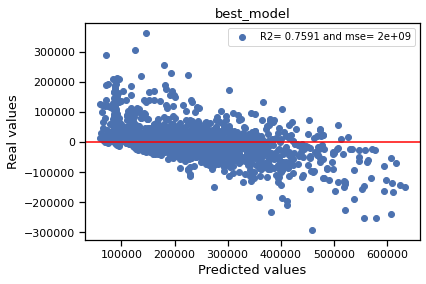

In [95]:
model_test(best_model, 'best_model', X_test, y_test)

### Прогноз по входным данным

In [96]:
# Загрузка и предобработка тестовых данных
test = df_read_csv('test')
df_type_cast('test', 'Rooms', 'int64')
df_type_cast('test', 'HouseFloor', 'int64')
test = optimizing_df(test)
df_save = test

Test:	5000	 sales and 19 features
New Type 'Rooms': int64
New Type 'HouseFloor': int64


In [97]:
# Применяем весь пакет Fix функций
test = data_prepare(test)

In [98]:
# Названия признаков
test_features = list(X_train.columns)

In [99]:
# Визуально проверяем результат обработки датасета
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                5000 non-null   uint8  
 1   Square               5000 non-null   float32
 2   DistrictId           5000 non-null   uint8  
 3   Social_1             5000 non-null   uint8  
 4   Helthcare_2          5000 non-null   uint8  
 5   Social_2             5000 non-null   uint16 
 6   Shops_1              5000 non-null   uint8  
 7   Floor                5000 non-null   uint8  
 8   HouseFloor           5000 non-null   uint8  
 9   LifeSquare           5000 non-null   float32
 10  Social_3             5000 non-null   uint8  
 11  Ecology_1            5000 non-null   float32
 12  KitchenSquare        5000 non-null   float32
 13  HouseYear            5000 non-null   uint16 
 14  cluster_year         5000 non-null   uint8  
 15  mean_price_dr        5000 non-null   f

In [100]:
# Запускаем обучение на тестовых данных
test['Price'] = best_model.predict(test[test_features])

mu = 215327.08 and sigma = 80352.78


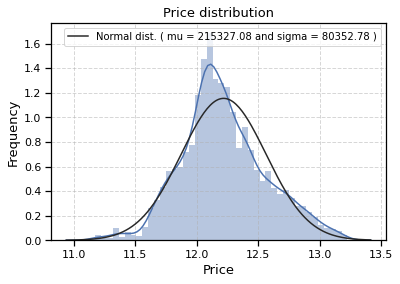

In [101]:
# Визуализация результата с исправлением искажений
price_log = np.log1p(test['Price'])
sns.distplot(price_log, fit=norm)
mu, sigma = norm.fit(test['Price'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')
plt.grid(linestyle='--', alpha=0.5)
plt.legend([f'Normal dist. ( mu = {mu:.2f} and sigma = {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')
plt.show()

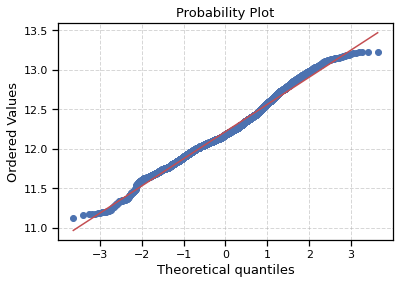

In [102]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [103]:
# Прогноз переводим в датафрейм
target = test[['Id', 'Price']]

In [104]:
# Присоединяем к датасету прогноз
df_save = pd.merge(df_save, target, left_on=None)

In [105]:
# Проверяем результат
df_save

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2,49.882645,33.432781,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,161652.128181
1,15856,74,2,69.263184,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,248086.946592
2,5480,190,1,13.597818,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,119964.111843
3,15664,47,2,73.046608,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,285506.739053
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A,133557.954385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3,67.133911,50.809795,6.0,5,9,1973,0.000170,B,B,36,5992,0,NaN,1,1,B,235137.052129
4996,4695,1,1,40.198471,21.807060,10.0,12,17,2017,0.007122,B,B,1,264,0,NaN,0,1,B,136235.890606
4997,5783,12,3,77.842178,48.282623,9.0,23,22,1989,0.090799,B,B,74,19083,2,NaN,5,15,B,338549.686564
4998,4780,62,2,81.305222,NaN,0.0,4,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,189151.193715


__Сохранение данных__

In [106]:
# Сохраняем прогноз в отдельный файл
test[['Id', 'Price']].to_csv('VSmirnov_predictions.csv', index=None)

In [107]:
# Сохраняем весь датасет Test + Прогноз в файл
df_save.to_csv('Test_predictions.csv', index=None)